<a href="https://colab.research.google.com/github/Surendra58/AI/blob/master/ProtoNets_Omniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Networks
### on the Omniglot Dataset

## Setup

In [ ]:
# Clone the repository
!git clone https://github.com/theneuralbeing/prototypical_networks

Cloning into 'prototypical_networks'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 54 (delta 27), reused 54 (delta 27), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [ ]:
cd prototypical_networks/

/content/prototypical_networks


In [ ]:
# Download
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
# Unzip to omniglot/ folder
!unzip images_background.zip
!unzip images_evaluation.zip

## Imports

In [ ]:
import numpy as np
import os
import cv2
from scipy import ndimage
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torchvision

## Load Dataset

In [ ]:
def load_characters(root, alphabet):
    '''
    Loads the characters from a given alphabet
    Args:
        root (str): Root directory
        alphabet (str): folder name of alphabet
    Returns:
        (tuple) of:
            (list): images
            (list): labels
    '''
    X = []
    y = []
    
    alphabet_path = os.path.join(root, alphabet)
    characters = os.listdir(alphabet_path)
    
    for char in characters:
        char_path = os.path.join(alphabet_path, char)
        images = os.listdir(char_path)
        
        for img in images:
            image = cv2.imread(os.path.join(char_path, img))
            image = cv2.resize(image, (28, 28)) / 255
            
            # Augmentations to add 3 new classes by rotating each class
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            
            X.extend((image, rotated_90, rotated_180, rotated_270))
            y.extend((f'{alphabet}_{char}_0', 
                      f'{alphabet}_{char}_90', 
                      f'{alphabet}_{char}_180', 
                      f'{alphabet}_{char}_270'))
    
    return X, y

In [ ]:
def load_data(root):
    '''
    Loads the full omniglot dataset from a root directory
    Args:
        root (str): path of omniglot dataset
    Returns:
        (tuple) of:
            (ndarray): images
            (ndarray): labels
    '''
    X_data = []
    y_data = []
    
    alphabets = os.listdir(root)
    for alphabet in tqdm(alphabets):
        X, y = load_characters(root, alphabet)
        X_data.extend(X)
        y_data.extend(y)
    
    return np.array(X_data), np.array(y_data)

In [ ]:
X_train, y_train = load_data('images_background/')

In [ ]:
X_eval, y_eval = load_data('images_evaluation/')

## Task Generation

In [ ]:
def extract_sample(X_data, y_data, k_shot=5, n_way=8, n_query=5, permute=True):
    '''
    Extract a random sample as a k-shot n-way task
    Args:
        X_data (ndarray): images
        y_data (ndarray): labels
        k_shot (int): number of images per class
        n_way (int): number of classes in the task
        n_query (int): number of query images
        permute (bool): flag to shuffle the classes or not. For training this must be set to True.
    Returns:
        (ndarray): sampled images of shape (n_way, k_shot + n_query, 28, 28, 3)
    '''
    sample = []
    
    # Randomly select n_way classes
    sampled_cls = np.random.choice(np.unique(y_data), n_way, replace=False)
    
    # Only useful for extracting samples with no query images during prediction on unlablled data
    if not permute:
        sampled_cls = np.unique(y_data)[:n_way]
        
    
    for c in sampled_cls:
        # Select images belonging to that class
        X_data_c = X_data[y_data == c]
        
        # Sample k_shot+n_query images
        sample_images = np.random.permutation(X_data_c)[:(k_shot+n_query)]
        sample.append(sample_images)

    sample = np.array(sample)
    # Convert to tensor and permute the images as channels first
    sample = torch.from_numpy(sample).float().permute(0, 1, 4, 2, 3)
    
    return sample

In [ ]:
def display_sample(sample):
    '''Display the samples of the task as a grid'''
    # Reshape to 4-dimensions from 5-dimensions
    sample_4d = sample.view(sample.shape[0]*sample.shape[1], *sample.shape[2:])
    
    # Make a grid
    out = torchvision.utils.make_grid(sample_4d, nrow=sample.shape[1])
    
    plt.figure(figsize = (16,7))
    plt.imshow(out.permute(1, 2, 0))

In [ ]:
test_sample = extract_sample(X_train, y_train, k_shot=5, n_way=8, n_query=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


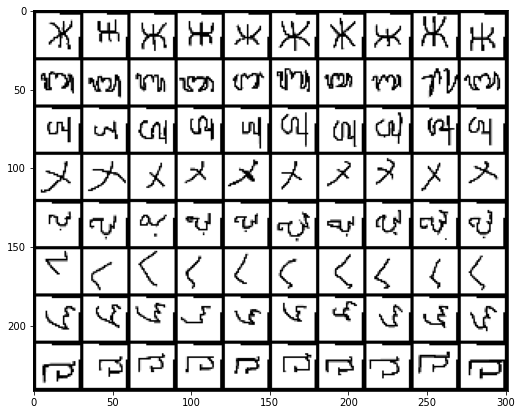

In [ ]:
display_sample(test_sample)

## Model

In [ ]:
class Image2Vector(nn.Module):
    def __init__(self):
        super(Image2Vector, self).__init__()
        
        self.input_block = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2))
        
        self.conv_block = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2))
    def forward(self, x):
        
        x = self.input_block(x)
        x = self.conv_block(x)
        x = self.conv_block(x)
        x = self.conv_block(x)
        
        # Output of shape (batch_size, 64)
        out = x.view(x.size(0), -1)
        
        return out

In [ ]:
class ProtoNet(nn.Module):
    '''ProtoNet Model for usage with known/labelled data'''
    def __init__(self):
        super(ProtoNet, self).__init__()
        
        self.encoder = Image2Vector()
    
    def forward(self, sample, k_shot, n_way, n_query, device):
        '''Forward pass
        Args:
            sample (torch.Tensor): sample of shape (n_way, k_shot + n_query, 28, 28, 3)
            k_shot (int): number of images per class
            n_way (int): number of classes
            n_query (int): number of query images per class
        
        Returns:
            tuple of:
                loss, dict of loss value, accuracy, predictions
        '''
        # Get the support set and query set images
        support = sample[:, :k_shot]
        queries = sample[:, k_shot:]
        
        # Get the target indices
        targets = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long().to(device)
        
        # Concatenate support set and query set along the 0th dimension
        x = torch.cat([support.contiguous().view(n_way * k_shot, *support.size()[2:]), 
                       queries.contiguous().view(n_way * n_query, *queries.size()[2:])], 0)
        
        # Get the embeddings
        embeds = self.encoder(x)
        z_dim = embeds.size(-1)
        
        # Compute Prototypes
        protos = embeds[:n_way * k_shot].view(n_way, k_shot, z_dim).mean(1)
        
        # Get query embeddings
        query_embeds = embeds[n_way * k_shot:]
        
        # Compute Distances
        distances = self.euclidean(query_embeds, protos)
        
        # Compute Log Softmax over the inverse of euclidean distances
        log_p = F.log_softmax(-distances, dim=1).view(n_way, n_query, -1)
        
        # Compute the negative of log softmax for correct classes (NLL)
        # and calculate the mean NLL loss
        loss = -log_p.gather(2, targets).squeeze().view(-1).mean()
                
        # Get predictions and calculate accuracy
        y_hat = log_p.argmax(2)
        accuracy = torch.eq(y_hat, targets.squeeze()).float().mean()
        
        return loss, {'loss': loss.item(), 
                      'preds': y_hat, 
                      'acc': accuracy.item()}
        
        
    def euclidean(self, queries, protos):
        '''
        Calculates Euclidean Distances between queries and prototypes
        Args:
            queries (torch.Tensor): shape (n, d) where n is n_way*n_query
            protos (torch.Tensor): shape (m, d) where m is n_way
        Returns:
            (torch.Tensor): shape (n, m) i.e. for each query the euclidean distances
                            to each of the prototypes
        '''
        n = queries.size(0)
        m = protos.size(0)
        d = queries.size(1)
        
        # Reshaping the queries and prototypes for distance calculation
        queries = queries.unsqueeze(1).expand(n, m, d)
        protos = protos.unsqueeze(0).expand(n, m, d)
        
        distance = torch.pow(queries - protos, 2).sum(2) # of shape n x m
        
        return distance

In [ ]:
model = ProtoNet()

## Training

In [ ]:
from tqdm.notebook import tnrange

In [ ]:
def train(model, X_data, y_data, optimizer, device='cuda', 
          k_shot=5, n_way=60, n_query=5, epochs=5, episodes=2000):
    '''
    Trains the ProtoNet on k-shot n-way task
    Args:
        model
        X_data (torch.Tensor): images
        y_data (torch.Tensor): labels
        optimizer
        k_shot (int): number of support images per class
        n_way (int): number of classes
        n_query (int): number of query images per class
        epochs (int): maximum epochs
        episodes (int): number of steps per epoch
    '''
    
    model.to(device)
    model.train()
    # Create LR scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5)
    
    for epoch in range(epochs):
        print('Epoch {:d} Started...'.format(epoch+1))
        train_losses = 0
        train_accuracies = 0
        
        for episode in tnrange(episodes, desc='Epoch {:d}'.format(epoch+1)):
            optimizer.zero_grad()
            
            # Extract sample
            sample = extract_sample(X_data, y_data, k_shot, n_way, n_query).to(device)
            
            # Forward Pass on ProtoNet
            loss, stats = model(sample, k_shot, n_way, n_query, device)
            
            # Backprop and Optimize
            loss.backward()
            optimizer.step()
            
            # Get Stats
            train_losses += stats['loss']
            train_accuracies += stats['acc']
            
            if episode % 200 == 0:
                print('At Episode {:d} -- Loss {:.5f} - Acc: {:.3f}'.format(episode, stats['loss'], stats['acc']))
        
        # Print Epoch Stats
        mean_loss = train_losses / episodes
        mean_acc = train_accuracies / episodes
        print('Epoch {:d} -- Loss: {:.5f} - Acc: {:.3f}\n'.format(epoch+1, mean_loss, mean_acc))
        
        # Scheduler Step
        scheduler.step()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
train(model, X_train, y_train, optimizer, device='cuda', k_shot=5, n_way=60, n_query=5, epochs=8, episodes=2000)

Epoch 1 Started...


At Episode 0 -- Loss 2.27824 - Acc: 0.540
At Episode 200 -- Loss 0.56162 - Acc: 0.847
At Episode 400 -- Loss 0.27499 - Acc: 0.927
At Episode 600 -- Loss 0.29937 - Acc: 0.907
At Episode 800 -- Loss 0.17339 - Acc: 0.937
At Episode 1000 -- Loss 0.13937 - Acc: 0.957
At Episode 1200 -- Loss 0.22515 - Acc: 0.933
At Episode 1400 -- Loss 0.15883 - Acc: 0.953
At Episode 1600 -- Loss 0.16091 - Acc: 0.953
At Episode 1800 -- Loss 0.17292 - Acc: 0.940

Epoch 1 -- Loss: 0.28257 - Acc: 0.912

Epoch 2 Started...


At Episode 0 -- Loss 0.15325 - Acc: 0.947
At Episode 200 -- Loss 0.11692 - Acc: 0.960
At Episode 400 -- Loss 0.11905 - Acc: 0.953
At Episode 600 -- Loss 0.14669 - Acc: 0.943
At Episode 800 -- Loss 0.13468 - Acc: 0.940
At Episode 1000 -- Loss 0.14746 - Acc: 0.970
At Episode 1200 -- Loss 0.14085 - Acc: 0.960
At Episode 1400 -- Loss 0.13405 - Acc: 0.953
At Episode 1600 -- Loss 0.13471 - Acc: 0.950
At Episode 1800 -- Loss 0.12697 - Acc: 0.953

Epoch 2 -- Loss: 0.13426 - Acc: 0.956

Epoch 3 Started...


At Episode 0 -- Loss 0.11281 - Acc: 0.967
At Episode 200 -- Loss 0.06277 - Acc: 0.983
At Episode 400 -- Loss 0.17606 - Acc: 0.930
At Episode 600 -- Loss 0.11365 - Acc: 0.960
At Episode 800 -- Loss 0.14644 - Acc: 0.957
At Episode 1000 -- Loss 0.12646 - Acc: 0.960
At Episode 1200 -- Loss 0.06087 - Acc: 0.987
At Episode 1400 -- Loss 0.10918 - Acc: 0.960
At Episode 1600 -- Loss 0.15225 - Acc: 0.957
At Episode 1800 -- Loss 0.09997 - Acc: 0.967

Epoch 3 -- Loss: 0.12060 - Acc: 0.961

Epoch 4 Started...


At Episode 0 -- Loss 0.09383 - Acc: 0.977
At Episode 200 -- Loss 0.17082 - Acc: 0.943
At Episode 400 -- Loss 0.12548 - Acc: 0.953
At Episode 600 -- Loss 0.12934 - Acc: 0.960
At Episode 800 -- Loss 0.17823 - Acc: 0.963
At Episode 1000 -- Loss 0.13251 - Acc: 0.953
At Episode 1200 -- Loss 0.05928 - Acc: 0.987
At Episode 1400 -- Loss 0.15409 - Acc: 0.957
At Episode 1600 -- Loss 0.07473 - Acc: 0.980
At Episode 1800 -- Loss 0.18361 - Acc: 0.960

Epoch 4 -- Loss: 0.11220 - Acc: 0.964

Epoch 5 Started...


At Episode 0 -- Loss 0.07645 - Acc: 0.980
At Episode 200 -- Loss 0.09657 - Acc: 0.970
At Episode 400 -- Loss 0.14569 - Acc: 0.937
At Episode 600 -- Loss 0.10584 - Acc: 0.973
At Episode 800 -- Loss 0.06314 - Acc: 0.977
At Episode 1000 -- Loss 0.10471 - Acc: 0.960
At Episode 1200 -- Loss 0.13033 - Acc: 0.963
At Episode 1400 -- Loss 0.04774 - Acc: 0.987
At Episode 1600 -- Loss 0.13310 - Acc: 0.950
At Episode 1800 -- Loss 0.16355 - Acc: 0.940

Epoch 5 -- Loss: 0.11003 - Acc: 0.965

Epoch 6 Started...


At Episode 0 -- Loss 0.17318 - Acc: 0.943
At Episode 200 -- Loss 0.11860 - Acc: 0.970
At Episode 400 -- Loss 0.09059 - Acc: 0.967
At Episode 600 -- Loss 0.13425 - Acc: 0.960
At Episode 800 -- Loss 0.16072 - Acc: 0.950
At Episode 1000 -- Loss 0.14058 - Acc: 0.953
At Episode 1200 -- Loss 0.06956 - Acc: 0.973
At Episode 1400 -- Loss 0.14393 - Acc: 0.957
At Episode 1600 -- Loss 0.07623 - Acc: 0.973
At Episode 1800 -- Loss 0.12931 - Acc: 0.950

Epoch 6 -- Loss: 0.10862 - Acc: 0.964

Epoch 7 Started...


At Episode 0 -- Loss 0.13108 - Acc: 0.957
At Episode 200 -- Loss 0.12316 - Acc: 0.973
At Episode 400 -- Loss 0.08779 - Acc: 0.967
At Episode 600 -- Loss 0.13539 - Acc: 0.957
At Episode 800 -- Loss 0.17648 - Acc: 0.953
At Episode 1000 -- Loss 0.18308 - Acc: 0.947
At Episode 1200 -- Loss 0.06374 - Acc: 0.983
At Episode 1400 -- Loss 0.16441 - Acc: 0.943
At Episode 1600 -- Loss 0.08506 - Acc: 0.963
At Episode 1800 -- Loss 0.12806 - Acc: 0.957

Epoch 7 -- Loss: 0.10908 - Acc: 0.965

Epoch 8 Started...


At Episode 0 -- Loss 0.11292 - Acc: 0.960
At Episode 200 -- Loss 0.09103 - Acc: 0.970
At Episode 400 -- Loss 0.05978 - Acc: 0.983
At Episode 600 -- Loss 0.21387 - Acc: 0.923
At Episode 800 -- Loss 0.06563 - Acc: 0.983
At Episode 1000 -- Loss 0.13624 - Acc: 0.947
At Episode 1200 -- Loss 0.09951 - Acc: 0.983
At Episode 1400 -- Loss 0.07658 - Acc: 0.980
At Episode 1600 -- Loss 0.06318 - Acc: 0.980
At Episode 1800 -- Loss 0.09128 - Acc: 0.980

Epoch 8 -- Loss: 0.10842 - Acc: 0.965



In [ ]:
# Save
torch.save(model.state_dict(), 'protonet.pt')

## Evaluation

In [ ]:
def evaluate(model, X_data, y_data, device='cuda', 
             k_shot=5, n_way=5, n_query=5, episodes=1000):
    '''
    Evaluate the ProtoNet on k-shot n-way task on the test set
    Args:
        model
        X_data (torch.Tensor): images
        y_data (torch.Tensor): labels
        k_shot (int): number of support images per class
        n_way (int): number of classes
        n_query (int): number of query images per class
        episodes (int): number of steps/episodes
    '''
    
    model.to(device)
    model.eval()
   
    test_losses = 0
    test_accuracies = 0

    for episode in tnrange(episodes, desc='Evaluating'):            
        # Extract sample
        sample = extract_sample(X_data, y_data, k_shot, n_way, n_query).to(device)

        # Forward Pass on ProtoNet
        loss, stats = model(sample, k_shot, n_way, n_query, device)

        # Get Stats
        test_losses += stats['loss']
        test_accuracies += stats['acc']

        if episode % 200 == 0:
            print('At Episode {:d} -- Loss {:.5f} - Acc: {:.3f}'.format(episode, stats['loss'], stats['acc']))

    # Print Epoch Stats
    mean_loss = test_losses / episodes
    mean_acc = test_accuracies / episodes
    print('Evaluation Results -- Loss: {:.5f} - Acc: {:.3f}\n'.format(mean_loss, mean_acc))

In [ ]:
evaluate(model, X_eval, y_eval, device='cuda', k_shot=5, n_way=5, n_query=5, episodes=1000)

At Episode 0 -- Loss 0.00006 - Acc: 1.000
At Episode 200 -- Loss 0.12775 - Acc: 0.960
At Episode 400 -- Loss 0.00396 - Acc: 1.000
At Episode 600 -- Loss 0.00043 - Acc: 1.000
At Episode 800 -- Loss 0.00097 - Acc: 1.000

Evaluation Results -- Loss: 0.04326 - Acc: 0.989



### Test on single sample

In [ ]:
device = 'cuda'
k_shot = 5
n_way = 5
n_query = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


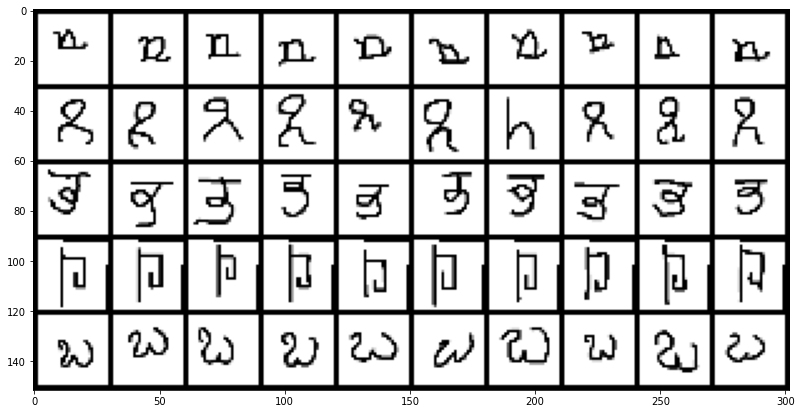

In [ ]:
# Sample a set from test set
my_sample = extract_sample(X_eval, y_eval, k_shot, n_way, n_query).to(device)
display_sample(my_sample.cpu())

In [ ]:
# Predict
loss, stats = model(my_sample, k_shot, n_way, n_query, device)
stats

{'acc': 1.0, 'loss': 0.03314891830086708, 'preds': tensor([[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]], device='cuda:0')}

## Prediction on unlabelled Query Images
Making predictions on unlabelled query images given a new support set.

In [ ]:
from collections import Counter

In [ ]:
def read_support_set(support_dir):
    '''
    Read a Support Set from a directory
    Args:
        support_dir (str): folder containing the support set with each sub-folder being a class.
                           Each class should have equal number of images i.e. consistent k_shot
    Returns:
        tuple of:
            (ndarray): X images
            (ndarray): y labels
            (dict) of: k_shot (int) and n_way (int)
            
    '''
    labels = os.listdir(support_dir)
    n_way = len(labels)
    
    X_support = []
    y_support = []
    
    for label in labels:
        label_path = os.path.join(support_dir, label)
        images = os.listdir(label_path)
        
        for img in images:
            image = cv2.imread(os.path.join(label_path, img))
            image = cv2.resize(image, (28, 28)) / 255
            
            X_support.append(image)
            y_support.append(label)
            
    k_shot = len(y_support) // n_way
            
    assert len(set(dict(Counter(y_support)).values())) == 1, 'Each Class should have equal number of images'
            
    return np.array(X_support), np.array(y_support), {'k_shot': k_shot, 'n_way': n_way}

In [ ]:
def read_query_set(query_dir):
    '''
    Read a Query Set from a directory
    Args:
        query_dir (str): folder containing the unlabelled query images
    '''
    images = os.listdir(query_dir)
    
    X_query = []
    
    for img in images:
        image = cv2.imread(os.path.join(query_dir, img))
        image = cv2.resize(image, (28, 28)) / 255

        X_query.append(image)
            
    return np.array(X_query)

In [ ]:
def predict(model, X_support, y_support, X_query, k_shot, n_way, n_query, device='cuda'):
    '''
    Make Predictions on new sets with unlabelled query images
    Args:
        X_support (ndarray): support set images
        y_support (ndarray): support set labels
        X_query (ndarray): unlabelled query images
        k_shot (int): number of images per class
        n_way (int): number of classes
        n_query (int): number of query images
    Returns:
        (tuple) of:
            (tensor): predictions
            (tensor): support samples
            (tensor): queries samples
    '''
    model.to(device)
    model.eval()
    
    # Convert support set images to sample format (5D)
    support = extract_sample(X_support, y_support, k_shot, n_way, n_query=0, permute=False).to(device)
    
    # Convert queries to tensor (4D)
    queries = torch.from_numpy(X_query).float().permute(0, 3, 1, 2).to(device)
    
    # Concatenate support set and query set along the 0th dimension
    x = torch.cat([support.contiguous().view(n_way * k_shot, *support.size()[2:]), 
                   queries.contiguous()], 0)
        
    # Compute embeddings
    embeds = model.encoder(x)
    z_dim = embeds.size(-1)
    
    # Compute Prototypes
    protos = embeds[:n_way * k_shot].view(n_way, k_shot, z_dim).mean(1)
        
    # Get query embeddings
    query_embeds = embeds[n_way * k_shot:]
    
    # Compute Distances
    distances = model.euclidean(query_embeds, protos)
    
    # Compute Softmax over the inverse of euclidean distances
    log_p = F.softmax(-distances, dim=1)
    
    # Compute Predictions
    y_hat = log_p.argmax(1)
    
    return y_hat, support, queries

In [ ]:
X_support, y_support, task = read_support_set('prediction/support-2shot/')

In [ ]:
X_query = read_query_set('prediction/query-2shot/')

In [ ]:
# Make predictions
preds, support, queries = predict(model, X_support, y_support, X_query,
                                  k_shot=task['k_shot'], n_way=task['n_way'], n_query=len(X_query), 
                                  device='cuda')

tensor([1, 0, 2, 5, 6, 9, 8, 4, 7, 3], device='cuda:0')


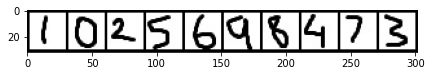

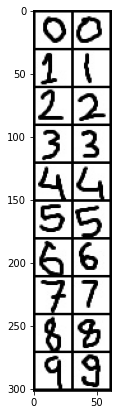

In [ ]:
print(preds)
# Display Query images
query_out = torchvision.utils.make_grid(queries.cpu(), nrow=len(queries))
plt.figure(figsize = (7,7))
plt.imshow(query_out.permute(1, 2, 0))
# Display Support images
display_sample(support.cpu())